In [108]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys

sys.path.append(os.path.abspath(os.path.join("../")))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from numba import jit

import helper_libraries.results_tools as results_tools

In [154]:
# Params
use_overnight = False

# Load data
forecast_oss_df, forecast_ins_df = results_tools.load_model_results(
    overnight=use_overnight, oos_periods=2, debug=True
)
fret_df, hrf_df = results_tools.load_mkt_rf_returns(overnight=use_overnight)
spread_df = results_tools.load_spreads()

Loading the following model results...
--------------------------------------------------
Folder        No_overnight
Overnight            False
OOSPeriods               2
Predictors             All
--------------------------------------------------


In [162]:
# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 0.9",
    "MS Strategy 0.5",
]
model_name_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]


(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_df,
    spread_df,
    fret_df['ff__mkt'],
    hrf_df['rf'],
    strategies_list,
    model_list,
    drop_overnight=False,
    hold_cash=False,
)

In [163]:
oss_weights_all_df

Benchmark                                          \
                       Market Sign Positive      Tanh MS Strategy 0.9   
datetime                                                                
1998-01-02 09:45:00       1.0  1.0      1.0  0.932696             1.0   
1998-01-02 10:00:00       1.0  1.0      1.0  0.969517             1.0   
1998-01-02 10:15:00       1.0  1.0      1.0  0.438726             1.0   
1998-01-02 10:30:00       1.0  1.0      1.0  0.440183             1.0   
1998-01-02 10:45:00       1.0  1.0      1.0  0.907941             1.0   
...                       ...  ...      ...       ...             ...   
2020-12-31 15:00:00       1.0  1.0      1.0  0.201959             0.0   
2020-12-31 15:15:00       1.0 -1.0      0.0  0.000000             0.0   
2020-12-31 15:30:00       1.0  1.0      1.0  0.247186             0.0   
2020-12-31 15:45:00       1.0  1.0      1.0  0.055487             0.0   
2020-12-31 16:00:00       1.0  1.0      1.0  0.308564             0.0   

                                        LR                              ...  \
                    MS Strategy 0.5 Market Sign Positive          Tanh  ...   
datetime                                                                ...   
1998-01-02 09:45:00             1.0    1.0  1.0      1.0  4.012595e-01  ...   
1998-01-02 10:00:00             1.0    1.0  1.0      1.0  3.802267e-01  ...   
1998-01-02 10:15:00             1.0    1.0  1.0      1.0  3.842203e-01  ...   
1998-01-02 10:30:00             1.0    1.0  1.0      1.0  3.859062e-01  ...   
1998-01-02 10:45:00             1.0    1.0  1.0      1.0  4.630540e-01  ...   
...                             ...    ...  ...      ...           ...  ...   
2020-12-31 15:00:00             0.0    1.0  1.0      1.0  1.095332e-12  ...   
2020-12-31 15:15:00             0.0    1.0  1.0      1.0  5.884067e-12  ...   
2020-12-31 15:30:00             0.0    1.0 -1.0      0.0  0.000000e+00  ...   
2020-12-31 15:45:00             0.0    1.0  1.0      1.0  9.456460e-12  ...   
2020-12-31 16:00:00             0.0    1.0  1.0      1.0  5.755491e-13  ...   

                    NN_pca_simple                                            \
                         Positive      Tanh MS Strategy 0.9 MS Strategy 0.5   
datetime                                                                      
1998-01-02 09:45:00           1.0  0.917314             1.0             1.0   
1998-01-02 10:00:00           1.0  0.925839             1.0             1.0   
1998-01-02 10:15:00           1.0  0.402551             1.0             1.0   
1998-01-02 10:30:00           1.0  0.272014             1.0             1.0   
1998-01-02 10:45:00           1.0  0.996565             1.0             1.0   
...                           ...       ...             ...             ...   
2020-12-31 15:00:00           0.0  0.000000             0.0             0.0   
2020-12-31 15:15:00           0.0  0.000000             0.0             0.0   
2020-12-31 15:30:00           0.0  0.000000             0.0             0.0   
2020-12-31 15:45:00           0.0  0.000000             0.0             0.0   
2020-12-31 16:00:00           0.0  0.000000             0.0             0.0   

                    NN_Lasso_simple                                          \
                             Market Sign Positive      Tanh MS Strategy 0.9   
datetime                                                                      
1998-01-02 09:45:00             1.0 -1.0      0.0  0.000000             0.0   
1998-01-02 10:00:00             1.0  1.0      1.0  0.664831             0.0   
1998-01-02 10:15:00             1.0 -1.0      0.0  0.000000             0.0   
1998-01-02 10:30:00             1.0 -1.0      0.0  0.000000             0.0   
1998-01-02 10:45:00             1.0  1.0      1.0  0.992315             1.0   
...                             ...  ...      ...       ...             ...   
2020-12-31 15:00:00             1.0  1.0      1.0  0.531309             

## Visualize

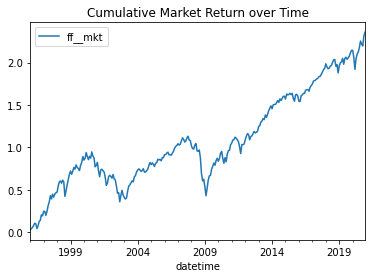

In [119]:
fret_df.groupby(pd.Grouper(freq = '1m')).sum().cumsum().plot()
plt.title('Cumulative Market Return over Time');

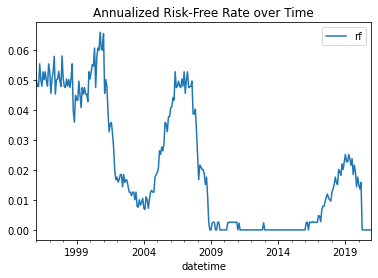

In [120]:
## Risk free
hrf_df.groupby(pd.Grouper(freq = '1m')).sum().pipe(lambda x: x*12).plot()
plt.title('Annualized Risk-Free Rate over Time');

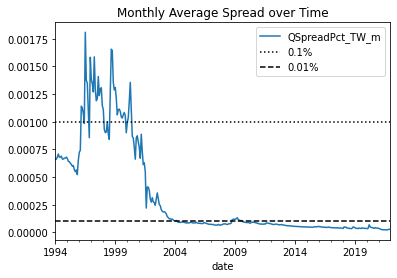

In [121]:
## Spreads
spread_df.groupby(pd.Grouper(freq = '1m')).mean().plot(y = 'QSpreadPct_TW_m')
plt.axhline(0.001, color = 'k', ls = ':', label = "0.1%")
plt.axhline(0.0001, color = 'k', ls = '--', label = "0.01%")
plt.legend()
plt.title('Monthly Average Spread over Time');

# Analyze

## R-Squared

In [131]:
forecast_oss_df["truth"] = fret_df["ff__mkt"]
forecast_ins_df["truth"] = fret_df["ff__mkt"]

#if over_night == 1:
#    rvol = pd.read_parquet('rvol_no_ovr.parquet')
# else:
#     rvol        = pd.read_parquet('rvol.parquet')

# forecast_oss_df["rvol"] = rvol["ff__mkt_rv_hat_intradaily"]
# forecast_ins_df["rvol"] = rvol["ff__mkt_rv_hat_intradaily"]



def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))


forecast_oss_df_positive = forecast_oss_df[forecast_oss_df>0]
forecast_oss_df_positive = forecast_oss_df_positive.fillna(0)

metrics_df_oss = pd.DataFrame([], index = [col for col in forecast_oss_df.columns if 'oss' in col])
metrics_df_ins = pd.DataFrame([], index = [col for col in forecast_ins_df.columns if 'oss' in col])


for col in forecast_oss_df.columns:
    if 'oss' in col:
        metrics_df_oss.loc[col, 'R2_oss'] = compute_rsquared(forecast_oss_df['truth'], forecast_oss_df[col])


for col in forecast_ins_df.columns:        
    if 'ins' in col:
        metrics_df_ins.loc[col, 'R2_ins'] = compute_rsquared(forecast_ins_df['truth'], forecast_ins_df[col])
        

print('OSS:')
display(metrics_df_oss.style.format("{:.3%}"))

print('insample:')
display(metrics_df_ins.style.format("{:.3%}"))

OSS:


,R2_oss
oss_Benchmark,0.095%
oss_Enet,0.129%
oss_LR,-50471641394533527191552.000%
oss_LR_Lasso_select,-0.007%
oss_LR_PCA_select,-0.049%
oss_Lasso,0.132%
oss_Lasso_PCA_select,0.103%
oss_NN,-0.079%
oss_NN_Lasso,-0.002%
oss_NN_Lasso_simple,-0.101%


insample:


,R2_ins
ins_Benchmark,0.088%
ins_Enet,0.202%
ins_LR,1.818%
ins_LR_Lasso_select,-0.008%
ins_LR_PCA_select,0.183%
ins_Lasso,0.202%
ins_Lasso_PCA_select,0.145%
ins_NN,1.930%
ins_NN_Lasso,-0.255%
ins_NN_Lasso_simple,0.302%


## Trading strategies

### Prep

In [144]:
# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Standard_error",
    "Tanh",
    "MS Strategy 0.9",
    "MS Strategy 0.5",
    "Spread-aware",
]
model_name_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Lasso_PCA_select",
    "NN",
    "NN_pca",
    "NN_Lasso",
    "NN_simple",
    "NN_pca_simple",
    "NN_Lasso_simple",
]

# True returns
returns_actual = forecast_oss_df["truth"]

## Useful variables
# Constants
n_years = (forecast_oss_df.index.max() - forecast_oss_df.index.min()).days / 365
n_obs_per_year = forecast_oss_df.groupby(pd.Grouper(freq="1y"))["truth"].count().mean()
n_obs = len(returns_actual)

# Risk-free rate
R_f = hrf_df['rf']

### Strategies

In [145]:
# Inputs are a dictionary with info about the model
# Includes model predictions
def get_weights_passive(model_info_dict):
    """Invest everything in the market."""

    # Just set weights to 1
    # Reuse prediction series to figure out index
    model_pred = model_info_dict["model_pred"]
    weights = model_pred * 0 + 1

    return weights


def get_weights_sign(model_info_dict):
    """Invest based on sign of forecast."""

    # Simply the sign of the predictions
    model_pred = model_info_dict["model_pred"]
    weights = np.sign(model_pred)

    return weights


def get_weights_sign_positive(model_info_dict):
    """Invest based on sign but no shorting"""

    # Sign of the predictions with negative
    # weights replaced with 0
    weights = get_weights_sign(model_info_dict)
    weights[weights < 0] = 0

    return weights


def get_weights_stderr(model_info_dict, cutoff):
    """Invest based on some standard error cutoff.
    Weights are non-negative, cutoff is a arg
    """

    # Invest whenever prediction exceeds cutoff
    model_pred = model_info_dict["model_pred"]
    model_pred_std = model_info_dict["model_pred_std"]
    weights = model_pred > cutoff * model_pred_std

    return weights


def get_weights_tanh(model_info_dict):
    """Invest with weights based on tanh of the
    z-score of the prediction; force positive weights
    """

    # Invest whenever prediction exceeds cutoff
    model_pred = model_info_dict["model_pred"]
    model_pred_std = model_info_dict["model_pred_std"]
    # y = (intradaily sharpe) * (annualization factor)
    y = model_pred / model_pred_std * np.sqrt(252*27)
    # z = standardized y
    z = y / np.std(y)
    # tanh of z
    weights = np.tanh(z)
    weights[model_pred < 0] = 0

    return weights


@jit
def compute_ms_weights_fast(trade_ind, cutoff):
    """Trade indicator could either be tanh(zscores)
    or just the sign of the model. The former
    is meant for the "0.5" and "0.9" style strategies,
    while the latter can be used to implement the
    "MS Positive" strategy by setting the cutoff to 0
    """

    n = np.shape(trade_ind)[0]
    weights = np.zeros(n)
    count_post = 0
    in_trade = 0

    for i in range(n):
        if trade_ind[i] > cutoff:
            in_trade = 1

        if trade_ind[i] < 0:
            in_trade = 0

        if in_trade == 1:
            # While we are holding,
            # the weight is set to one
            weights[i] = 1

    return weights


def get_weights_ms_strat(model_info_dict, cutoff):
    """Mathias's top secret trading strategy"""

    # Tanh of z-scores of predictions
    model_pred = model_info_dict["model_pred"]
    # model_pred_std = model_info_dict["model_pred_std"]
    model_pred_z_tanh = np.tanh(model_pred / np.std(model_pred))

    # Get weights using fast numba function
    X_tanh = model_pred_z_tanh.values
    weights = compute_ms_weights_fast(X_tanh, cutoff)
    weights = pd.Series(weights, index=model_pred.index)

    return weights

In [146]:
## Spread cognizant trading


@jit
def compute_spread_responsive_weights(prediction, riskfree, spread):
    """Return prediction comes from model. The cutoff is defined
    by the spread.
    """

    n = np.shape(prediction)[0]

    # Start with money in the market
    w = np.ones(n)

    for i in range(1, n):

        # Check if we should enter the market
        # will lose money from spread but gain the initial return
        if w[i - 1] == 0:
            if (prediction[i] - riskfree[i] - spread[i]) > 0:
                w[i] = 1
            else:
                w[i] = 0

        if w[i - 1] == 1:
            if (prediction[i] - riskfree[i] - spread[i]) < 0:
                w[i] = 0
            else:
                w[i] = 1

    return w


def get_weights_spread_strat(model_info_dict):
    """Spread-aware trading strategy"""

    # Tanh of z-scores of predictions
    model_pred = model_info_dict["model_pred"]
    spread = model_info_dict["spread"]
    riskfree = model_info_dict["riskfree"]

    # Get weights using fast numba function
    weights = compute_spread_responsive_weights(model_pred.values, riskfree.values, spread.values)
    weights = pd.Series(weights, index=model_pred.index)

    return weights

### Process

In [147]:
## Params
drop_overnight = False

In [148]:
# %%time

# Output
oss_results_list = []
oss_returns_list = []
oss_weights_list = []
oss_trading_list = []
oss_retpred_list = []

# Drop overnight?
if drop_overnight:
    market_returns = returns_actual.loc[returns_actual.index.time != dt.time(9, 30)]
    riskfree_returns = R_f.loc[returns_actual.index.time != dt.time(9, 30)]
else:
    market_returns = returns_actual
    riskfree_returns = R_f.loc[returns_actual.index]

# Main loop
for model_idx, model_col_name in enumerate(forecast_oss_df.columns):

    if "oss" not in model_col_name:
        continue
    else:
        print(f"Processing: {model_col_name}")

    # Storing results for each model
    oss_results_model = pd.DataFrame([], index=strategies_list)

    for strategy_idx, strategy_name in enumerate(strategies_list):

        # Basic info
        model_name = model_name_list[model_idx]

        # Model predictions
        model_pred = forecast_oss_df[model_col_name]
        # model_pred_std = np.std(model_pred)
        model_pred_std = (
            pd.read_parquet("../../Results/RV/RV_HAR_oss.parquet")
            .pipe(np.sqrt)
            .iloc[:, 0]
            .loc[model_pred.index]
        )

        # Put into dictionary
        model_info_dict = {}
        model_info_dict["model_pred"] = model_pred
        model_info_dict["model_pred_std"] = model_pred_std
        model_info_dict["spread"] = spread_df["QSpreadPct_TW_m"].loc[model_pred.index]
        model_info_dict["riskfree"] = riskfree_returns

        # Get trading strategy results
        if strategy_name == "Market":
            weights = get_weights_passive(model_info_dict)
        elif strategy_name == "Sign":
            weights = get_weights_sign(model_info_dict)
        elif strategy_name == "Positive":
            weights = get_weights_sign_positive(model_info_dict)
        elif strategy_name == "Standard_error":
            weights = get_weights_stderr(model_info_dict, 1)  #################
        elif strategy_name == "Tanh":
            weights = get_weights_tanh(model_info_dict)
        elif strategy_name == "MS Strategy 0.5":
            weights = get_weights_ms_strat(model_info_dict, 0.5)
        elif strategy_name == "MS Strategy 0.9":
            weights = get_weights_ms_strat(model_info_dict, 0.9)
        elif strategy_name == "MS positive":
            weights = get_weights_ms_strat_pos(model_info_dict)
        elif strategy_name == "Spread-aware":
            weights = get_weights_spread_strat(model_info_dict)
        else:
            raise Exception("Unknown trading strategy: ", strategy_name)

        # Convert to float
        weights = weights.astype(float)

        # Drop overnight?
        if drop_overnight:
            weights = weights.loc[weights.index.time != dt.time(9, 30)]
            # If drop overnight, market returns and riskfree returns will also differ
            # these were adjusted before the start of the loop

        # Strategy statistics
        portfolio_returns = weights * market_returns + (1 - weights) * (riskfree_returns)
        portfolio_turnover = weights.diff(1).fillna(0).abs()

        # Radj = R - |w_diff|*tau
        portfolio_returns_adj = portfolio_returns - portfolio_turnover.to_frame("turnover").join(
            spread_df[["QSpreadPct_TW_m"]]/2
        ).prod(axis=1)

        # Averages
        portfolio_average_return = portfolio_returns.sum() / n_years
        portfolio_average_return_adj = portfolio_returns_adj.sum() / n_years
        portfolio_average_excess_return = (portfolio_returns - R_f).sum() / n_years
        portfolio_average_excess_return_adj = (portfolio_returns_adj - R_f).sum() / n_years
        portfolio_average_turnover = portfolio_turnover.sum() / n_years
        portfolio_average_vol = np.sqrt(np.square(portfolio_returns).sum() / n_years)
        portfolio_sharpe = portfolio_average_excess_return / portfolio_average_vol
        portfolio_sharpe_adj = portfolio_average_excess_return_adj / portfolio_average_vol

        # Save results to dataframe
        oss_results_model.loc[strategy_name, "Return"] = round(portfolio_average_return, 2)
        oss_results_model.loc[strategy_name, "ReturnAdj"] = round(portfolio_average_return_adj, 2)
        oss_results_model.loc[strategy_name, "Trades"] = round(portfolio_average_turnover, 1)
        oss_results_model.loc[strategy_name, "Sharpe"] = round(portfolio_sharpe, 2)
        oss_results_model.loc[strategy_name, "SharpeAdj"] = round(portfolio_sharpe_adj, 2)
        oss_results_model.loc[strategy_name, "rvol"] = round(portfolio_average_vol, 2)
        oss_results_model.loc[strategy_name, "Name (col)"] = model_col_name
        oss_results_model.loc[strategy_name, "Name"] = model_name
        oss_returns_model = portfolio_returns
        oss_returns_model.name = (model_name, strategy_name)
        oss_weights_model = weights
        oss_weights_model.name = (model_name, strategy_name)

        # Append to running list of returns
        oss_returns_list.append(oss_returns_model)
        oss_weights_list.append(oss_weights_model)

    # Model predictions
    oss_retpred_model = model_pred
    oss_retpred_model.name = (model_name)
    oss_retpred_list.append(oss_retpred_model)
        
    # Append to running list of results
    oss_results_list.append(oss_results_model)

KeyError: "[Timestamp('1998-11-27 13:15:00'), Timestamp('1998-11-27 13:30:00'), Timestamp('1998-11-27 13:45:00'), Timestamp('1998-11-27 14:00:00'), Timestamp('1998-11-27 14:15:00'), Timestamp('1998-11-27 14:30:00'), Timestamp('1998-11-27 14:45:00'), Timestamp('1998-11-27 15:00:00'), Timestamp('1998-11-27 15:15:00'), Timestamp('1998-11-27 15:30:00'), Timestamp('1998-11-27 15:45:00'), Timestamp('1998-11-27 16:00:00'), Timestamp('1998-12-24 13:30:00'), Timestamp('1998-12-24 13:45:00'), Timestamp('1998-12-24 14:00:00'), Timestamp('1998-12-24 14:15:00'), Timestamp('1998-12-24 14:30:00'), Timestamp('1998-12-24 14:45:00'), Timestamp('1998-12-24 15:00:00'), Timestamp('1998-12-24 15:15:00'), Timestamp('1998-12-24 15:30:00'), Timestamp('1998-12-24 15:45:00'), Timestamp('1998-12-24 16:00:00'), Timestamp('1999-11-26 13:30:00'), Timestamp('1999-11-26 13:45:00'), Timestamp('1999-11-26 14:00:00'), Timestamp('1999-11-26 14:15:00'), Timestamp('1999-11-26 14:30:00'), Timestamp('1999-11-26 14:45:00'), Timestamp('1999-11-26 15:00:00'), Timestamp('1999-11-26 15:15:00'), Timestamp('1999-11-26 15:30:00'), Timestamp('1999-11-26 15:45:00'), Timestamp('1999-11-26 16:00:00'), Timestamp('1999-12-31 13:30:00'), Timestamp('1999-12-31 13:45:00'), Timestamp('1999-12-31 14:00:00'), Timestamp('1999-12-31 14:15:00'), Timestamp('1999-12-31 14:30:00'), Timestamp('1999-12-31 14:45:00'), Timestamp('1999-12-31 15:00:00'), Timestamp('1999-12-31 15:15:00'), Timestamp('1999-12-31 15:30:00'), Timestamp('1999-12-31 15:45:00'), Timestamp('1999-12-31 16:00:00'), Timestamp('2000-07-03 13:15:00'), Timestamp('2000-07-03 13:30:00'), Timestamp('2000-07-03 13:45:00'), Timestamp('2000-07-03 14:00:00'), Timestamp('2000-07-03 14:15:00'), Timestamp('2000-07-03 14:30:00'), Timestamp('2000-07-03 14:45:00'), Timestamp('2000-07-03 15:00:00'), Timestamp('2000-07-03 15:15:00'), Timestamp('2000-07-03 15:30:00'), Timestamp('2000-07-03 15:45:00'), Timestamp('2000-07-03 16:00:00'), Timestamp('2000-11-24 13:15:00'), Timestamp('2000-11-24 13:30:00'), Timestamp('2000-11-24 13:45:00'), Timestamp('2000-11-24 14:00:00'), Timestamp('2000-11-24 14:15:00'), Timestamp('2000-11-24 14:30:00'), Timestamp('2000-11-24 14:45:00'), Timestamp('2000-11-24 15:00:00'), Timestamp('2000-11-24 15:15:00'), Timestamp('2000-11-24 15:30:00'), Timestamp('2000-11-24 15:45:00'), Timestamp('2000-11-24 16:00:00'), Timestamp('2001-07-03 13:15:00'), Timestamp('2001-07-03 13:30:00'), Timestamp('2001-07-03 13:45:00'), Timestamp('2001-07-03 14:00:00'), Timestamp('2001-07-03 14:15:00'), Timestamp('2001-07-03 14:30:00'), Timestamp('2001-07-03 14:45:00'), Timestamp('2001-07-03 15:00:00'), Timestamp('2001-07-03 15:15:00'), Timestamp('2001-07-03 15:30:00'), Timestamp('2001-07-03 15:45:00'), Timestamp('2001-07-03 16:00:00'), Timestamp('2001-11-23 13:15:00'), Timestamp('2001-11-23 13:30:00'), Timestamp('2001-11-23 13:45:00'), Timestamp('2001-11-23 14:00:00'), Timestamp('2001-11-23 14:15:00'), Timestamp('2001-11-23 14:30:00'), Timestamp('2001-11-23 14:45:00'), Timestamp('2001-11-23 15:00:00'), Timestamp('2001-11-23 15:15:00'), Timestamp('2001-11-23 15:30:00'), Timestamp('2001-11-23 15:45:00'), Timestamp('2001-11-23 16:00:00'), Timestamp('2001-12-24 13:15:00'), Timestamp('2001-12-24 13:30:00'), Timestamp('2001-12-24 13:45:00'), Timestamp('2001-12-24 14:00:00'), Timestamp('2001-12-24 14:15:00'), Timestamp('2001-12-24 14:30:00'), Timestamp('2001-12-24 14:45:00'), Timestamp('2001-12-24 15:00:00'), Timestamp('2001-12-24 15:15:00'), Timestamp('2001-12-24 15:30:00'), Timestamp('2001-12-24 15:45:00'), Timestamp('2001-12-24 16:00:00'), Timestamp('2002-07-05 13:15:00'), Timestamp('2002-07-05 13:30:00'), Timestamp('2002-07-05 13:45:00'), Timestamp('2002-07-05 14:00:00'), Timestamp('2002-07-05 14:15:00'), Timestamp('2002-07-05 14:30:00'), Timestamp('2002-07-05 14:45:00'), Timestamp('2002-07-05 15:00:00'), Timestamp('2002-07-05 15:15:00'), Timestamp('2002-07-05 15:30:00'), Timestamp('2002-07-05 15:45:00'), Timestamp('2002-07-05 16:00:00'), Timestamp('2002-11-29 13:15:00'), Timestamp('2002-11-29 13:30:00'), Timestamp('2002-11-29 13:45:00'), Timestamp('2002-11-29 14:00:00'), Timestamp('2002-11-29 14:15:00'), Timestamp('2002-11-29 14:30:00'), Timestamp('2002-11-29 14:45:00'), Timestamp('2002-11-29 15:00:00'), Timestamp('2002-11-29 15:15:00'), Timestamp('2002-11-29 15:30:00'), Timestamp('2002-11-29 15:45:00'), Timestamp('2002-11-29 16:00:00'), Timestamp('2002-12-24 13:15:00'), Timestamp('2002-12-24 13:30:00'), Timestamp('2002-12-24 13:45:00'), Timestamp('2002-12-24 14:00:00'), Timestamp('2002-12-24 14:15:00'), Timestamp('2002-12-24 14:30:00'), Timestamp('2002-12-24 14:45:00'), Timestamp('2002-12-24 15:00:00'), Timestamp('2002-12-24 15:15:00'), Timestamp('2002-12-24 15:30:00'), Timestamp('2002-12-24 15:45:00'), Timestamp('2002-12-24 16:00:00'), Timestamp('2003-07-03 13:30:00'), Timestamp('2003-07-03 13:45:00'), Timestamp('2003-07-03 14:00:00'), Timestamp('2003-07-03 14:15:00'), Timestamp('2003-07-03 14:30:00'), Timestamp('2003-07-03 14:45:00'), Timestamp('2003-07-03 15:00:00'), Timestamp('2003-07-03 15:15:00'), Timestamp('2003-07-03 15:30:00'), Timestamp('2003-07-03 15:45:00'), Timestamp('2003-07-03 16:00:00'), Timestamp('2003-11-28 13:15:00'), Timestamp('2003-11-28 13:30:00'), Timestamp('2003-11-28 13:45:00'), Timestamp('2003-11-28 14:00:00'), Timestamp('2003-11-28 14:15:00'), Timestamp('2003-11-28 14:30:00'), Timestamp('2003-11-28 14:45:00'), Timestamp('2003-11-28 15:00:00'), Timestamp('2003-11-28 15:15:00'), Timestamp('2003-11-28 15:30:00'), Timestamp('2003-11-28 15:45:00'), Timestamp('2003-11-28 16:00:00'), Timestamp('2003-12-24 13:15:00'), Timestamp('2003-12-24 13:30:00'), Timestamp('2003-12-24 13:45:00'), Timestamp('2003-12-24 14:00:00'), Timestamp('2003-12-24 14:15:00'), Timestamp('2003-12-24 14:30:00'), Timestamp('2003-12-24 14:45:00'), Timestamp('2003-12-24 15:00:00'), Timestamp('2003-12-24 15:15:00'), Timestamp('2003-12-24 15:30:00'), Timestamp('2003-12-24 15:45:00'), Timestamp('2003-12-24 16:00:00'), Timestamp('2003-12-26 13:15:00'), Timestamp('2003-12-26 13:30:00'), Timestamp('2003-12-26 13:45:00'), Timestamp('2003-12-26 14:00:00'), Timestamp('2003-12-26 14:15:00'), Timestamp('2003-12-26 14:30:00'), Timestamp('2003-12-26 14:45:00'), Timestamp('2003-12-26 15:00:00'), Timestamp('2003-12-26 15:15:00'), Timestamp('2003-12-26 15:30:00'), Timestamp('2003-12-26 15:45:00'), Timestamp('2003-12-26 16:00:00'), Timestamp('2004-11-26 13:30:00'), Timestamp('2004-11-26 13:45:00'), Timestamp('2004-11-26 14:00:00'), Timestamp('2004-11-26 14:15:00'), Timestamp('2004-11-26 14:30:00'), Timestamp('2004-11-26 14:45:00'), Timestamp('2004-11-26 15:00:00'), Timestamp('2004-11-26 15:15:00'), Timestamp('2004-11-26 15:30:00'), Timestamp('2004-11-26 15:45:00'), Timestamp('2004-11-26 16:00:00'), Timestamp('2005-11-25 13:30:00'), Timestamp('2005-11-25 13:45:00'), Timestamp('2005-11-25 14:00:00'), Timestamp('2005-11-25 14:15:00'), Timestamp('2005-11-25 14:30:00'), Timestamp('2005-11-25 14:45:00'), Timestamp('2005-11-25 15:00:00'), Timestamp('2005-11-25 15:15:00'), Timestamp('2005-11-25 15:30:00'), Timestamp('2005-11-25 15:45:00'), Timestamp('2005-11-25 16:00:00'), Timestamp('2006-07-03 13:30:00'), Timestamp('2006-07-03 13:45:00'), Timestamp('2006-07-03 14:00:00'), Timestamp('2006-07-03 14:15:00'), Timestamp('2006-07-03 14:30:00'), Timestamp('2006-07-03 14:45:00'), Timestamp('2006-07-03 15:00:00'), Timestamp('2006-07-03 15:15:00'), Timestamp('2006-07-03 15:30:00'), Timestamp('2006-07-03 15:45:00'), Timestamp('2006-07-03 16:00:00'), Timestamp('2006-11-24 13:30:00'), Timestamp('2006-11-24 13:45:00'), Timestamp('2006-11-24 14:00:00'), Timestamp('2006-11-24 14:15:00'), Timestamp('2006-11-24 14:30:00'), Timestamp('2006-11-24 14:45:00'), Timestamp('2006-11-24 15:00:00'), Timestamp('2006-11-24 15:15:00'), Timestamp('2006-11-24 15:30:00'), Timestamp('2006-11-24 15:45:00'), Timestamp('2006-11-24 16:00:00'), Timestamp('2007-12-24 16:00:00'), Timestamp('2015-11-27 13:15:00'), Timestamp('2015-11-27 13:30:00'), Timestamp('2015-11-27 13:45:00'), Timestamp('2015-11-27 14:00:00'), Timestamp('2015-11-27 14:15:00'), Timestamp('2015-11-27 14:30:00'), Timestamp('2015-11-27 14:45:00'), Timestamp('2015-11-27 15:00:00'), Timestamp('2015-11-27 15:15:00'), Timestamp('2015-11-27 15:30:00'), Timestamp('2015-11-27 15:45:00'), Timestamp('2015-11-27 16:00:00'), Timestamp('2015-12-24 13:15:00'), Timestamp('2015-12-24 13:30:00'), Timestamp('2015-12-24 13:45:00'), Timestamp('2015-12-24 14:00:00'), Timestamp('2015-12-24 14:15:00'), Timestamp('2015-12-24 14:30:00'), Timestamp('2015-12-24 14:45:00'), Timestamp('2015-12-24 15:00:00'), Timestamp('2015-12-24 15:15:00'), Timestamp('2015-12-24 15:30:00'), Timestamp('2015-12-24 15:45:00'), Timestamp('2015-12-24 16:00:00'), Timestamp('2016-11-25 13:15:00'), Timestamp('2016-11-25 13:30:00'), Timestamp('2016-11-25 13:45:00'), Timestamp('2016-11-25 14:00:00'), Timestamp('2016-11-25 14:15:00'), Timestamp('2016-11-25 14:30:00'), Timestamp('2016-11-25 14:45:00'), Timestamp('2016-11-25 15:00:00'), Timestamp('2016-11-25 15:15:00'), Timestamp('2016-11-25 15:30:00'), Timestamp('2016-11-25 15:45:00'), Timestamp('2016-11-25 16:00:00'), Timestamp('2017-07-03 13:15:00'), Timestamp('2017-07-03 13:30:00'), Timestamp('2017-07-03 13:45:00'), Timestamp('2017-07-03 14:00:00'), Timestamp('2017-07-03 14:15:00'), Timestamp('2017-07-03 14:30:00'), Timestamp('2017-07-03 14:45:00'), Timestamp('2017-07-03 15:00:00'), Timestamp('2017-07-03 15:15:00'), Timestamp('2017-07-03 15:30:00'), Timestamp('2017-07-03 15:45:00'), Timestamp('2017-07-03 16:00:00'), Timestamp('2017-11-24 13:15:00'), Timestamp('2017-11-24 13:30:00'), Timestamp('2017-11-24 13:45:00'), Timestamp('2017-11-24 14:00:00'), Timestamp('2017-11-24 14:15:00'), Timestamp('2017-11-24 14:30:00'), Timestamp('2017-11-24 14:45:00'), Timestamp('2017-11-24 15:00:00'), Timestamp('2017-11-24 15:15:00'), Timestamp('2017-11-24 15:30:00'), Timestamp('2017-11-24 15:45:00'), Timestamp('2017-11-24 16:00:00'), Timestamp('2018-07-03 13:15:00'), Timestamp('2018-07-03 13:30:00'), Timestamp('2018-07-03 13:45:00'), Timestamp('2018-07-03 14:00:00'), Timestamp('2018-07-03 14:15:00'), Timestamp('2018-07-03 14:30:00'), Timestamp('2018-07-03 14:45:00'), Timestamp('2018-07-03 15:00:00'), Timestamp('2018-07-03 15:15:00'), Timestamp('2018-07-03 15:30:00'), Timestamp('2018-07-03 15:45:00'), Timestamp('2018-07-03 16:00:00'), Timestamp('2018-11-23 13:15:00'), Timestamp('2018-11-23 13:30:00'), Timestamp('2018-11-23 13:45:00'), Timestamp('2018-11-23 14:00:00'), Timestamp('2018-11-23 14:15:00'), Timestamp('2018-11-23 14:30:00'), Timestamp('2018-11-23 14:45:00'), Timestamp('2018-11-23 15:00:00'), Timestamp('2018-11-23 15:15:00'), Timestamp('2018-11-23 15:30:00'), Timestamp('2018-11-23 15:45:00'), Timestamp('2018-11-23 16:00:00'), Timestamp('2018-12-24 13:15:00'), Timestamp('2018-12-24 13:30:00'), Timestamp('2018-12-24 13:45:00'), Timestamp('2018-12-24 14:00:00'), Timestamp('2018-12-24 14:15:00'), Timestamp('2018-12-24 14:30:00'), Timestamp('2018-12-24 14:45:00'), Timestamp('2018-12-24 15:00:00'), Timestamp('2018-12-24 15:15:00'), Timestamp('2018-12-24 15:30:00'), Timestamp('2018-12-24 15:45:00'), Timestamp('2018-12-24 16:00:00'), Timestamp('2019-07-03 13:15:00'), Timestamp('2019-07-03 13:30:00'), Timestamp('2019-07-03 13:45:00'), Timestamp('2019-07-03 14:00:00'), Timestamp('2019-07-03 14:15:00'), Timestamp('2019-07-03 14:30:00'), Timestamp('2019-07-03 14:45:00'), Timestamp('2019-07-03 15:00:00'), Timestamp('2019-07-03 15:15:00'), Timestamp('2019-07-03 15:30:00'), Timestamp('2019-07-03 15:45:00'), Timestamp('2019-07-03 16:00:00'), Timestamp('2019-11-29 13:15:00'), Timestamp('2019-11-29 13:30:00'), Timestamp('2019-11-29 13:45:00'), Timestamp('2019-11-29 14:00:00'), Timestamp('2019-11-29 14:15:00'), Timestamp('2019-11-29 14:30:00'), Timestamp('2019-11-29 14:45:00'), Timestamp('2019-11-29 15:00:00'), Timestamp('2019-11-29 15:15:00'), Timestamp('2019-11-29 15:30:00'), Timestamp('2019-11-29 15:45:00'), Timestamp('2019-11-29 16:00:00'), Timestamp('2019-12-24 13:15:00'), Timestamp('2019-12-24 13:30:00'), Timestamp('2019-12-24 13:45:00'), Timestamp('2019-12-24 14:00:00'), Timestamp('2019-12-24 14:15:00'), Timestamp('2019-12-24 14:30:00'), Timestamp('2019-12-24 14:45:00'), Timestamp('2019-12-24 15:00:00'), Timestamp('2019-12-24 15:15:00'), Timestamp('2019-12-24 15:30:00'), Timestamp('2019-12-24 15:45:00'), Timestamp('2019-12-24 16:00:00'), Timestamp('2020-11-27 13:15:00'), Timestamp('2020-11-27 13:30:00'), Timestamp('2020-11-27 13:45:00'), Timestamp('2020-11-27 14:00:00'), Timestamp('2020-11-27 14:15:00'), Timestamp('2020-11-27 14:30:00'), Timestamp('2020-11-27 14:45:00'), Timestamp('2020-11-27 15:00:00'), Timestamp('2020-11-27 15:15:00'), Timestamp('2020-11-27 15:30:00'), Timestamp('2020-11-27 15:45:00'), Timestamp('2020-11-27 16:00:00'), Timestamp('2020-12-24 13:15:00'), Timestamp('2020-12-24 13:30:00'), Timestamp('2020-12-24 13:45:00'), Timestamp('2020-12-24 14:00:00'), Timestamp('2020-12-24 14:15:00'), Timestamp('2020-12-24 14:30:00'), Timestamp('2020-12-24 14:45:00'), Timestamp('2020-12-24 15:00:00'), Timestamp('2020-12-24 15:15:00'), Timestamp('2020-12-24 15:30:00'), Timestamp('2020-12-24 15:45:00'), Timestamp('2020-12-24 16:00:00')] not in index"

In [58]:
# Merge results
oss_results_all_df = pd.concat(oss_results_list)
oss_returns_all_df = pd.concat(oss_returns_list, axis = 1)
oss_weights_all_df = pd.concat(oss_weights_list, axis = 1)
oss_retpred_all_df = pd.concat(oss_retpred_list, axis = 1)

In [143]:
oss_results_all_df

,Return,ReturnAdj,Trades,Sharpe,SharpeAdj,rvol,Name (col),Name
Market,0.00,0.00,0.0,-0.12,-0.12,0.15,oss_Benchmark,Benchmark
Sign,0.22,-0.42,5129.0,1.41,-2.94,0.15,oss_Benchmark,Benchmark
Positive,0.11,-0.21,2564.5,0.85,-2.02,0.11,oss_Benchmark,Benchmark
Tanh,0.09,-0.22,2209.2,0.96,-3.22,0.07,oss_Benchmark,Benchmark
MS Strategy 0.9,0.09,-0.08,607.2,1.01,-1.26,0.07,oss_Benchmark,Benchmark
...,...,...,...,...,...,...,...,...
Sign,0.17,-0.21,1130.0,1.00,-1.52,0.15,oss_NN_Lasso_simple,NN_Lasso_simple
Positive,0.08,-0.10,565.0,0.48,-0.88,0.14,oss_NN_Lasso_simple,NN_Lasso_simple
Tanh,0.08,-0.11,671.8,1.09,-2.21,0.06,oss_NN_Lasso_simple,NN_Lasso_simple
MS Strategy 0.9,0.04,-0.02,140.9,0.26,-0.39,0.10,oss_NN_Lasso_simple,NN_Lasso_simple


<AxesSubplot:xlabel='datetime'>

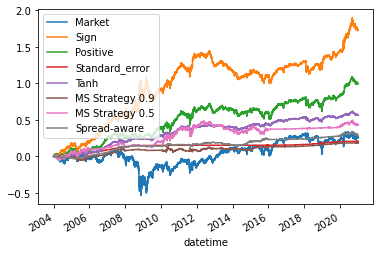

In [59]:
# Example returns
oss_returns_all_df['Lasso_PCA_select'].cumsum().plot()

In [60]:
# oss_trading_all_df['Lasso_PCA_select'].plot()

### Save

In [61]:
oss_results_all_df.to_parquet('../../Results/trading_results/results.parquet')
oss_returns_all_df.to_parquet('../../Results/trading_results/returns.parquet')
oss_weights_all_df.to_parquet('../../Results/trading_results/weights.parquet')
oss_retpred_all_df.to_parquet('../../Results/trading_results/retpred.parquet')

## Sharpe

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

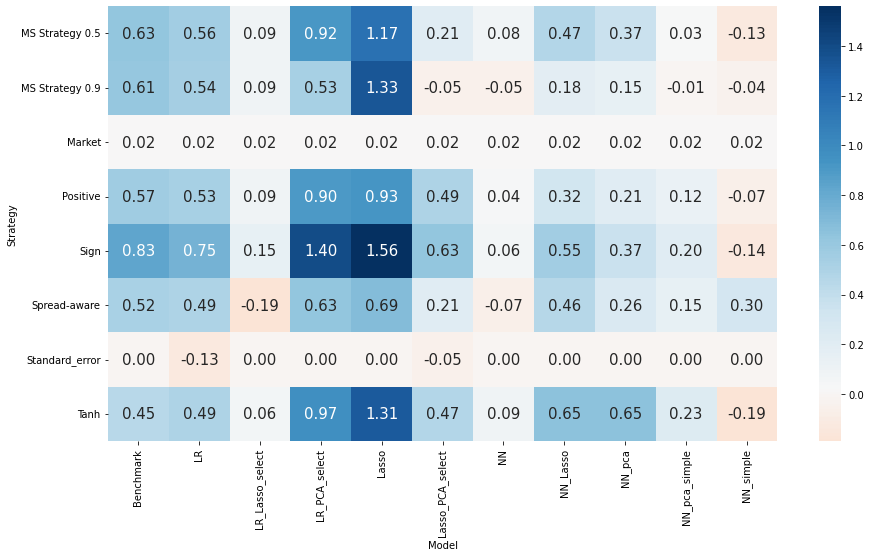

In [62]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Sharpe")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

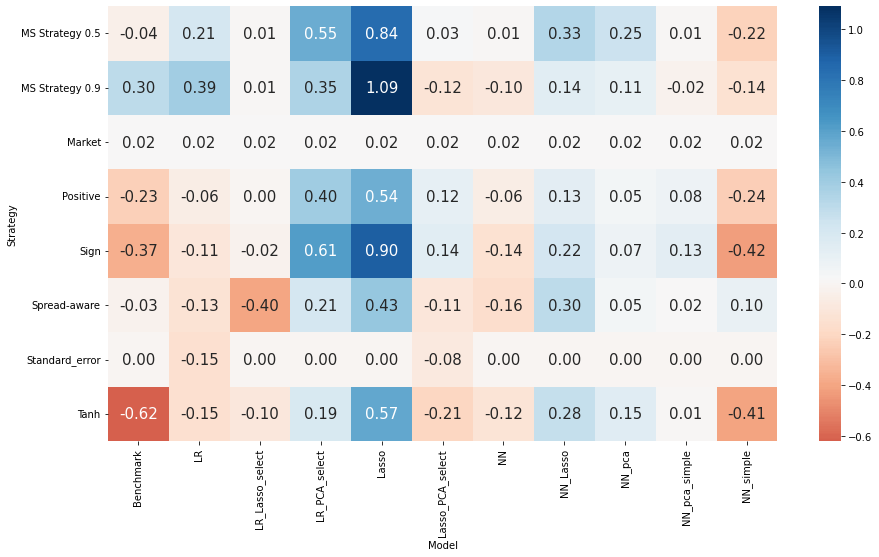

In [63]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="SharpeAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Returns

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

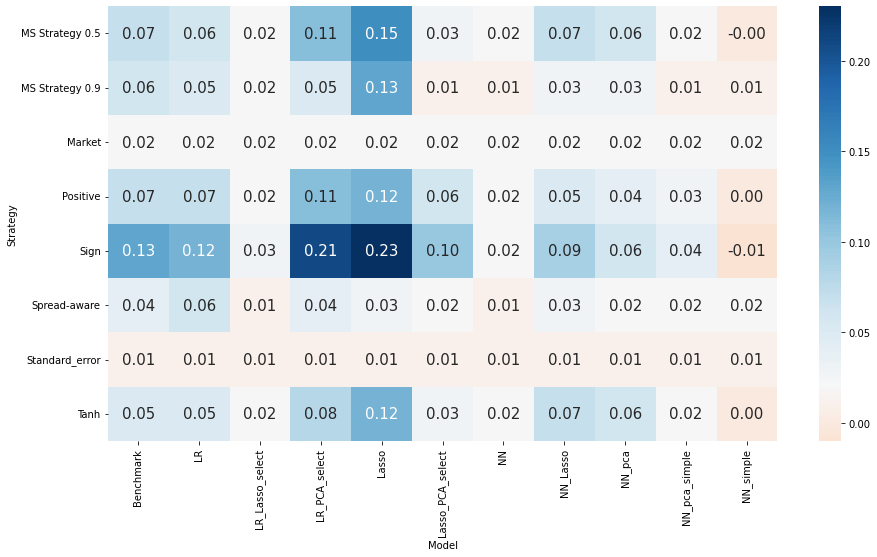

In [64]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Return")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

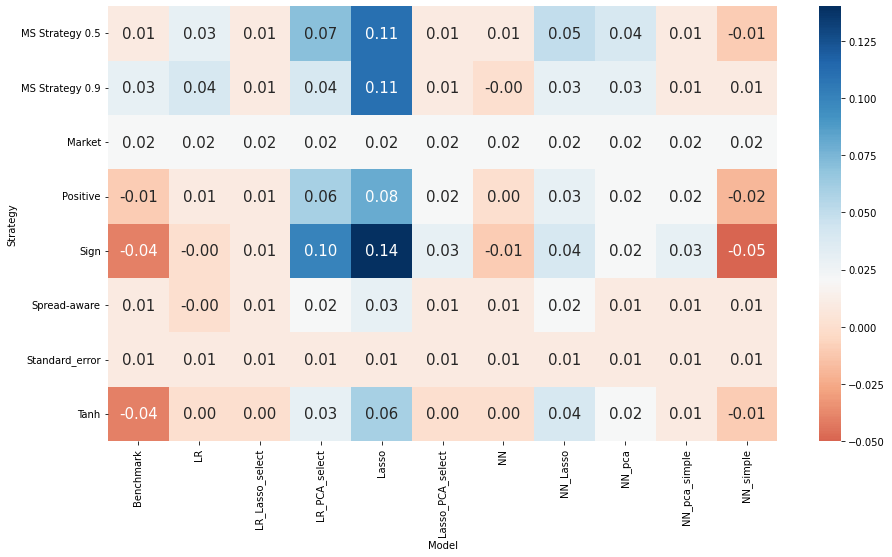

In [65]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="ReturnAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Turnover

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

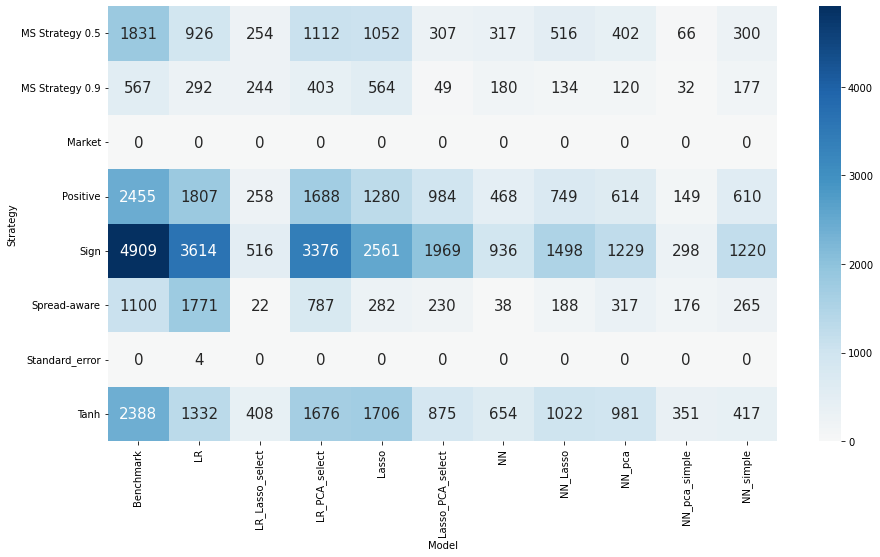

In [66]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Trades")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".0f",
    annot=True,
    annot_kws={"fontsize": 15},
)